In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import mixture
from scipy.stats import binom
from random import choice
import mixem
from mixem.distribution.distribution import Distribution
sns.set(style="darkgrid")
sns.set_context("paper")


## generate data from 3 binomial distros

[20. 33. 60.]


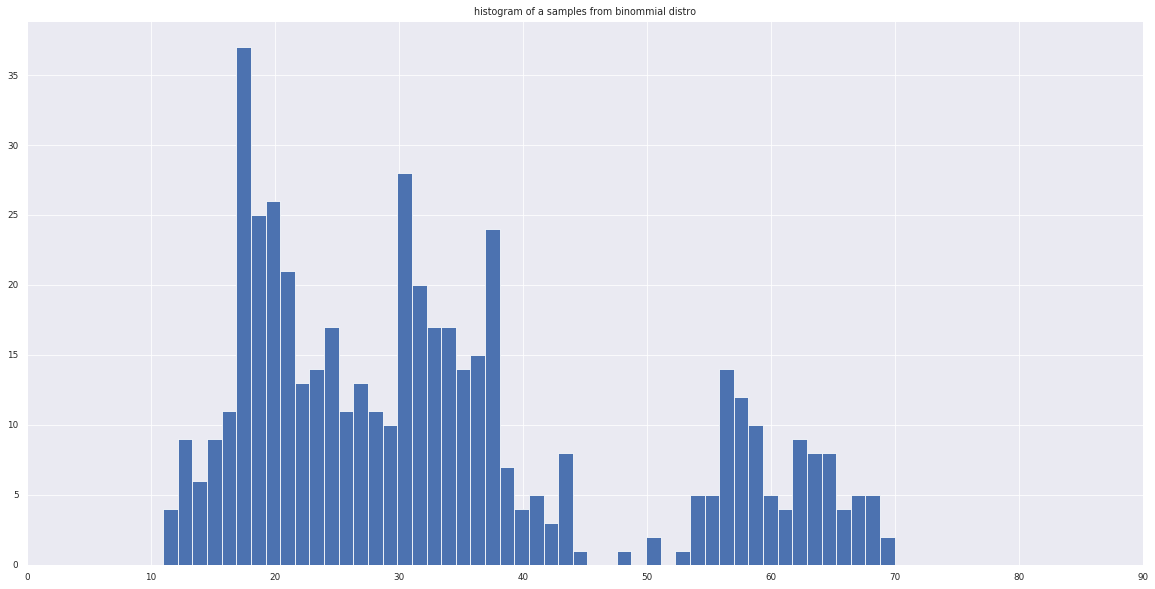

In [2]:
strainN = np.array([100,110,120])
strainP = np.array([.2, .3, .5])
strainMeans = strainN*strainP
print(strainMeans)
np.random.seed(2)
# x1 = 100*np.random.binomial(n, 0.2, 200)/n
# x2 = 100*np.random.binomial(n, 0.3, 200)/n
# x3 = 100*np.random.binomial(n, 0.5, 200)/n
x1 = np.random.binomial(strainN[0], strainP[0], 200)
x2 = np.random.binomial(strainN[1], strainP[1], 200)
x3 = np.random.binomial(strainN[2], strainP[2], 100)
X_ = np.concatenate((x1,x2,x3)).flatten()
X = np.array([(x,0) for x in X_])
plt.figure(figsize=(20,10))

plt.title('histogram of a samples from binommial distro')
plt.hist(X[:,0], bins=50)
plt.xticks(np.arange(0,100,10))
plt.show()
plt.close()

## Estimate proportions with K-means

In [3]:
km = KMeans(n_clusters=3)
km.fit(X)
k_means = km.cluster_centers_[:,0]
k_means = np.sort(k_means)
print("estimated means:", [int(mean) for mean in k_means])
# convert means to p
k_p = k_means/sum(k_means)
print("estimated p: ", k_p)

estimated means: [19, 33, 60]
estimated p:  [0.17129073 0.29793214 0.53077713]


## 3 Strain mixture.
## Create test data and do classification with Binomials and k-means estimates

In [9]:
np.random.seed(3)

# let the variable sequence be a string of SNPs [a,c,t,g...] such that each SNP has
# an associated count (number of occurences of its base in a SNP column of the pile)
sequence = []

# populate the sequence with data of the type {base, base count, pile depth, strain label}
for i in range(100):
    # each SNP column/pile has random depth from 90 to 130
    depth = np.random.randint(90,130)
    # we at random pick one of 3 strains and pick its proportion to generate a pile
    strainIndex = np.random.randint(0,3)
    # p is a proportion of a strain
    p = strainP[strainIndex]
    # produce an SNP pile which has the count of the base = success
    success = np.random.binomial(depth, p, 1)[0]
    # put it all together. 
    sequence.append([choice(['a','c','t','g']), success, depth, strainIndex])

# Do classification for each SNP
errorCount = 0
for snp in sequence:
    # Use 3 binomials with estimated means, we assume weights are uniform for each binom
    probabs = [binom.pmf(snp[1], snp[2], k_p[0]),    # params: success, depth, p
               binom.pmf(snp[1], snp[2], k_p[1]),
               binom.pmf(snp[1], snp[2], k_p[2])]
    strainInd = np.argmax(probabs)

    if strainInd != snp[3]:
        errorCount += 1
    
#     print("predicted strain index: ", strainInd, "actual strain index:", snp[3])

print('number of missclassifications:', errorCount, 'out of ', len(sequence))
print('error percent:', errorCount/len(sequence)*100, '%')

number of missclassifications: 5 out of  100
error percent: 5.0 %


## Implement Binomial class for EM algorithm

In [5]:

class BinomialDistribution(Distribution):
    """Binomial distribution with parameters (p, n)."""

    def __init__(self, p, n):
        self.p = p
        self.n = n

    def log_density(self, data, local_trials=None):
        assert(len(data.shape) == 1), "Expect 1D data!"
        if local_trials is not None:
            return np.log(binom.pmf(data, local_trials, self.p))
        else:
            return np.log(binom.pmf(data, self.n, self.p))

    def estimate_parameters(self, data, weights):
         self.p = np.sum(data*weights)/(np.sum(weights)*self.n)

    def __repr__(self):
        return "Binom[p={p:.4g}, trials={trials:.4g}]".format(p=self.p, trials=self.n)


## Learn Binomial Mixture and validate results

In [8]:
totalDepth = 0

for snp in sequence:
    totalDepth += int(snp[2])
    
avgDepth = totalDepth/len(sequence)


weights, distributions, log_like = mixem.em(X_,
[BinomialDistribution(p=0.1, n=avgDepth),
 BinomialDistribution(p=0.2, n=avgDepth),
 BinomialDistribution(p=0.3, n=avgDepth),],
 initial_weights=None, progress_callback=None, max_iterations=200)
print('weights:', weights)
print('distros:', distributions)

# Do classification for each SNP
errorCount = 0
for snp in sequence:
    probabs = [np.log(weights[0])+distributions[0].log_density(np.array([snp[1]]), snp[2]),
               np.log(weights[1])+distributions[1].log_density(np.array([snp[1]]), snp[2]),
               np.log(weights[2])+distributions[2].log_density(np.array([snp[1]]), snp[2])]
    strainInd = np.argmax(probabs)

    if strainInd != snp[3]:
        errorCount += 1
    
#     print("predicted strain index: ", strainInd, "actual strain index:", snp[3])

print('number of missclassifications:', errorCount, 'out of ', len(sequence))
print('error percent:', errorCount/len(sequence)*100, '%')

weights: [0.40084766 0.3995022  0.19965014]
distros: [Binom[p=0.1776, trials=110.3], Binom[p=0.3043, trials=110.3], Binom[p=0.5469, trials=110.3]]
number of missclassifications: 8 out of  100
error percent: 8.0 %


## Plot Binomial Mixture for a fixed n

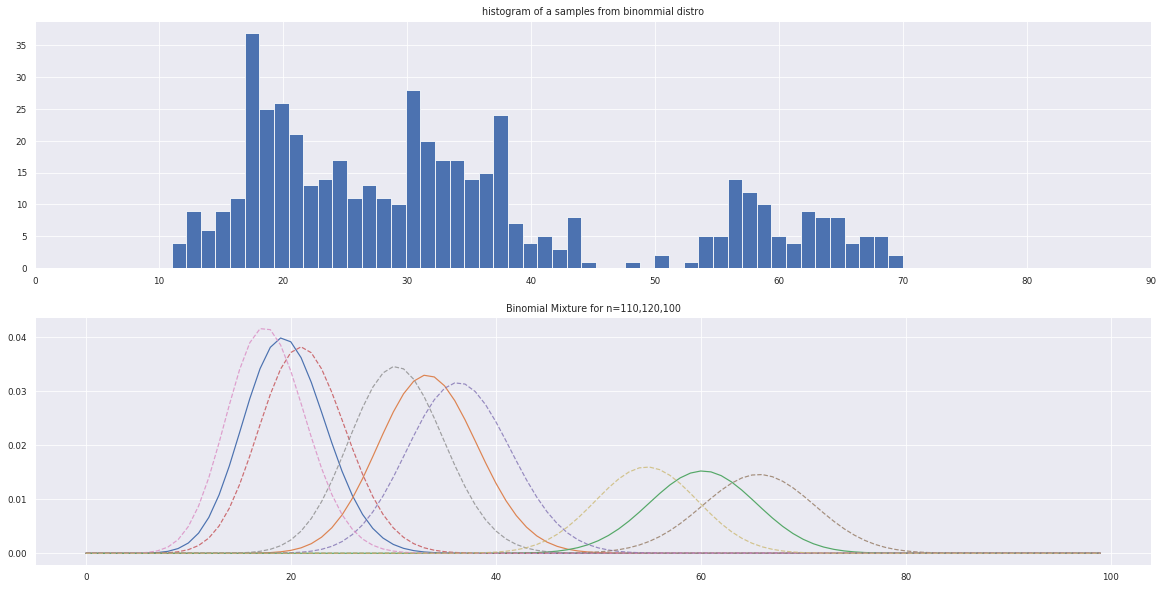

In [7]:
n1 = 110
n2 = 120
n3 = 100
a1 = 1
a2 = 0.8
a3 = 0.8
x_axis = np.arange(0,100)
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.title('histogram of a samples from binommial distro')
plt.hist(X[:,0], bins=50)
plt.xticks(np.arange(0,100,10))
plt.subplot(2,1,2)
plt.title(f'Binomial Mixture for n={n1},{n2},{n3}')
plt.plot(x_axis, weights[0]*np.exp(distributions[0].log_density(x_axis,n1)), alpha=a1)
plt.plot(x_axis, weights[1]*np.exp(distributions[1].log_density(x_axis,n1)), alpha=a1)
plt.plot(x_axis, weights[2]*np.exp(distributions[2].log_density(x_axis,n1)), alpha=a1)

plt.plot(x_axis, weights[0]*np.exp(distributions[0].log_density(x_axis,n2)), '--', alpha=a2)
plt.plot(x_axis, weights[1]*np.exp(distributions[1].log_density(x_axis,n2)), '--', alpha=a2)
plt.plot(x_axis, weights[2]*np.exp(distributions[2].log_density(x_axis,n2)), '--', alpha=a2)

plt.plot(x_axis, weights[0]*np.exp(distributions[0].log_density(x_axis,n3)), '--', alpha=a3)
plt.plot(x_axis, weights[1]*np.exp(distributions[1].log_density(x_axis,n3)), '--', alpha=a3)
plt.plot(x_axis, weights[2]*np.exp(distributions[2].log_density(x_axis,n3)), '--', alpha=a3)
plt.show()
plt.close()